<a href="https://colab.research.google.com/github/Risuo/Risuo.github.io/blob/master/train_%26_inference_buildings_model_Mask_RCNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
python3 nucleus.py train --dataset=/path/to/dataset --subset=train --weights=imagenet

In [0]:
import matplotlib
    # Agg backend runs without a display
#matplotlib.use('Agg')
import matplotlib.pyplot as plt
import matplotlib.patches as patches

import os
import sys
import json
import random
import math
import tensorflow as tf
import re
import time
import datetime
import numpy as np
import skimage.io
from imgaug import augmenters as iaa

# Root directories of the project
sys.path.append('/content/drive/My Drive/Capstone/Open Cities Competition/Mask_RCNN/')
sys.path.append('/content/drive/My Drive/Capstone/Open Cities Competition/Mask_RCNN/datasets')
sys.path.append('/content/drive/My Drive/Capstone/Open Cities Competition/Mask_RCNN/samples/nucleus')
sys.path.append('/content/drive/My Drive/Capstone/Open Cities Competition')

# Import Mask RCNN
from mrcnn.config import Config
from mrcnn import utils
from mrcnn import model as modellib
from mrcnn import visualize
from mrcnn.visualize import display_images
from mrcnn.model import log

# Path to trained weights file
COCO_WEIGHTS_PATH = '/content/drive/My Drive/Capstone/Open Cities Competition/Mask_RCNN/samples/coco/mask_rcnn_coco.h5'

# Directory to save logs and model checkpoints, if not provided
# through the command line argument --logs
DEFAULT_LOGS_DIR = '/content/drive/My Drive/Capstone/Open Cities Competition/Mask_RCNN/logs'

DATASET_DIR = '/content/drive/My Drive/Capstone/Open Cities Competition/Mask_RCNN/datasets/building/train_4992_a'

# Results directory
# Save submission files here
RESULTS_DIR = '/content/drive/My Drive/Capstone/Open Cities Competition/Mask_RCNN/results/buildings'

VAL_IMAGE_IDS = [
    "odgixRzV2A9GsOWR7yGWkDcf7AdHxrlvfFcFG8qxpE4",
    "VEl6kup9pAiTOc9B1tKDHRMeH_29SBUSxu0fszDG0AE",
    "1R61DUW5uy-zAk2LBaphg8Bkf1mRKtcSArkiYdq4OQY",
    "IFMWSI3D90Lw3rlpNXCEsYI319smfXVL_eX4tU8tO0k",
    "pnS55lLg0IfAU-hYZ_ZUtIi_JI01IfTGIBa2SVBu1Q8",
    "Bw8jQAP34TQXr3bVk5eN68PmO4JSZSs7FOLhy6_qEGc",
    "ah7Uj2f96DqSNwKF4rctoBYaGKy7m09EWC-PCosatP8",
    "kAJktpApTOXDz42HtqD84r9Erp0ywpX-tq0GXlbvclQ",
    "lRpMfzTum0fo_8vXO98TUPqBoF84VlFG7_CTA1aRG1c",
    "hEmgOrgKazUyqV9Wfx_pXgIRE-h9AVfKxlUJ0dAci4U",
    "bz3b3EPA910x4uHAzCr_dxAPkGnZhMM8VLCwOAEVP_s",
    "BrQSQ837Yl_BROM9BXPaJkOpsQ-YxzuFdVh4qwhqyhg",
    "FINAnjR_r-IdB3c5hPBKxRuz46rDOdEjzUnyxC4t5Ws",
    "TmIKIiMWHRhU3MqisV0kfcbpAaso-xf52WiSyK3_cK0",
    "EyXp4nx5wb8ML6gZC93-9Y0HGBvYhIMBsFJoL4VeYyk",
    "z-TDdPq2NxbziZPghieSUfJRudZd4T48_5yjEdzJHHY",
    "gUc9_ugIlVCAyR2ZG6zgdFxvtudnxYWpiB0ILd2uKmM",
    "wvgqUNsK28DRYGFzcxE0ieh9FkkLp53J0uFQH5nSe-g",
    "6tQhEr-tsCRD_QltXn-kYkksjGB9Xncp0R1Bfx53g0Q",
    "OqNSRiRLQNfARl2GpKjVbmJMIEPMUuVHsmhD-ehpvy0",
    "Kl7XMzPG-gcNKMSfhwDXTceblkI0PRNtobSiUiInAW8",
    "tsB4NtP3CSvwztX8b_c2BKojqScxj9XzwBuqtjxowYE",
    "qV9JxMyLl2rKX9R7zNHAD_QvRI31aJFgPsBdutl54nE",
    "YkyiW3h9pFI2z51m30Hn62tQkFXEhPiW9QNHfbGM0q4",
    "-TEd7R2IMDmlAHSEuAvaCLUDeLRgay_pXMYRZyo8Vrw",
    
    "hu0czuUunWp9lSTn6oU-_bJ10KmxjDA1tS1Sv2Q-vVc",
    "fM2TKRC2E1Vqi7IJRk_c2dc8cuYLVt1TMNRntB34HEc",
    "zbYiS6A8fHMoRuLM5RWSULgoLywGCETCA9hA_sPIRUo",
    "10d-iLSW7q48bbay8-ot5LU73u0hunG1pYDQohqhO7Q",
    "2Aa9k4b5ri7dxvfazeCr3wbNae4rUZvuvGtE4HMqwqI",
    "hnx0HPEJaTnM8Sjh18bc1b1rZ5-gcwgqUvnRjgtgXpo",
    "pAsVdEXtzGU4bveSiN_uguPLjJbxOeRmGJt2-syrrFg",
    "fwziasPjOV7NYIIbNNaL0s4iA5awsshJ1KIKawIhbwk",
    "HOU8FafTUEXqi75AdWT9-GmPiIBAPJZQv58aWpWtORE",
    "CUfijT5J8VPS47yhpr8JJvgFT7bBXYqKiUrlUESKlAM",
    "mA2o1XlSkSoHwl-11UEqWSVhzCsvXmR1dttE4LaJ9v4",
    "IgH7ILS3NwYzPyqb0DleVzDDw9Z4wohnh_WOyPsyBuQ",
    "pZLVtfyEVlMh-lTarBHpninXlVlTQxlZHPfzGpuYeHo",
    "KMnsLi1dG5UxIqoW3j5ri0Pt2zlj1uap5-McWT3dNRQ",
    "TwQ96OJT4JAU_7LLvwbgqmmNzXbuMWQ8G5opTtJdlb8",
    "JPdbmvSZI7hB8OH4YAWOFeQfVQ1Suf68QSc8L1x915g",
    "ie0Q9KZlX-iHJPwY74x_qNe2XUuBCxBdPq46lrCGzG0",
    "tIbHqEV_L5YFfRTVoH3mUd__NFmJ6P7zT7mGIM7zvdY",
    "_FNnlJ0JzusnzGMAftAIiqnm42QZlVqmJYbjYewaju4",
    "tg_atu0wvm17jNGE3CZ9cKPIoFItpcZ_nkkZggarCfU",
    "8XPnJpvRb5t1RTtYyUF9rBQ32Av3zst4h_Tf4siu3ro",
    "Uux4v-A1grv9kZEKC6Ed9u0ZRolGAVz0QABvSopXhac",
    "NnLoOn2PUrUsFqUN1DakSBcuvMzDU8OOD2y7Ny14buE",
    "DIpo3K5McQVxt1oD4doOPYi0GWEsZ8iinfR_9_BbVL0",
    "iYVfpYjqS5YRwitL4uN94yetS-bbWYc63AQWdlBzntU",
]

############################################################
#  Configurations
############################################################


In [0]:
class BuildingsConfig(Config):
    """Configuration for training on the toy shapes dataset.
    Derives from the base Config class and overrides values specific
    to the toy shapes dataset.
    """
    # Give the configuration a recognizable name
    NAME = "buildings"

    # Train on 1 GPU and 8 images per GPU. We can put multiple images on each
    # GPU because the images are small. Batch size is 8 (GPUs * images/GPU).
    GPU_COUNT = 1
    IMAGES_PER_GPU = 6

    # Number of classes (including background)
    NUM_CLASSES = 1 + 1  # background + 1 shapes

    # Number of training and validation steps per epoch
    STEPS_PER_EPOCH = (637 - len(VAL_IMAGE_IDS)) // IMAGES_PER_GPU
    VALIDATION_STEPS = max(1, len(VAL_IMAGE_IDS) // IMAGES_PER_GPU)

    # Don't exclude based on confidence. Since we have two classes
    # then 0.5 is the minimum anyway as it picks between nucleus and BG
    DETECTION_MIN_CONFIDENCE = 0

    # Backbone network architecture
    # Supported values are: resnet50, resnet101
    BACKBONE = "resnet50"

    # Input image resizing
    # Random crops of size 512x512
    IMAGE_RESIZE_MODE = "none"
    IMAGE_MIN_DIM = 512
    IMAGE_MAX_DIM = 512
    IMAGE_MIN_SCALE = 0

    # Length of square anchor side in pixels
    RPN_ANCHOR_SCALES = (16, 32, 64, 128, 256)

    # ROIs kept after non-maximum supression (training and inference)
    POST_NMS_ROIS_TRAINING = 1000
    POST_NMS_ROIS_INFERENCE = 2000

    # Non-max suppression threshold to filter RPN proposals.
    # You can increase this during training to generate more propsals.
    RPN_NMS_THRESHOLD = 0.7

    # How many anchors per image to use for RPN training
    RPN_TRAIN_ANCHORS_PER_IMAGE = 64

    # Image mean (RGB)
    # This is taken from the data inspection np.mean(image_color, axis=0) result
    MEAN_PIXEL = np.array([128.77, 118.85, 99.54])

    # If enabled, resizes instance masks to a smaller size to reduce
    # memory load. Recommended when using high-resolution images.
    USE_MINI_MASK = True
    MINI_MASK_SHAPE = (56, 56)  # (height, width) of the mini-mask

    # Number of ROIs per image to feed to classifier/mask heads
    # The Mask RCNN paper uses 512 but often the RPN doesn't generate
    # enough positive proposals to fill this and keep a positive:negative
    # ratio of 1:3. You can increase the number of proposals by adjusting
    # the RPN NMS threshold.
    # The data inspection used 32 here, so possibly revert
    TRAIN_ROIS_PER_IMAGE = 128

    # Maximum number of ground truth instances to use in one image
    MAX_GT_INSTANCES = 100

    # Max number of final detections per image
    DETECTION_MAX_INSTANCES = 200

    # Non-maximum suppression threshold for detection
    DETECTION_NMS_THRESHOLD = 0.3


In [0]:
def get_ax(rows=1, cols=1, size=8):
    """Return a Matplotlib Axes array to be used in
    all visualizations in the notebook. Provide a
    central point to control graph sizes.
    
    Change the default size attribute to control the size
    of rendered images
    """
    _, ax = plt.subplots(rows, cols, figsize=(size*cols, size*rows))
    return ax

############################################################
#  Dataset
############################################################

In [0]:
class BuildingDataset(utils.Dataset):

    def load_building(self, dataset_dir, subset):
        
        self.add_class("building", 1, "building")

        assert subset in ["train", "val"]

        # Get image ids from directory names
        # At this point, initial test, we're using a sub-set of 50 images as the
        # validation dataset. Eventually we will create a second dataset to be
        # exclusively used as the validation dataset. At that point, this code
        # will have to be updated
        # TODO: Update method to select proper directories for train/val subsets 
        if subset == 'val':
            image_ids = VAL_IMAGE_IDS
        else:
            image_ids = next(os.walk(dataset_dir))[1]
            if subset == 'train':
                image_ids = list(set(image_ids) - set(VAL_IMAGE_IDS))

        # Add the images
        for image_id in image_ids:
            self.add_image("building",
                           image_id = image_id,
                           path=os.path.join(dataset_dir, image_id, "image/{}.npy".format(image_id)))


    def load_image(self, image_id):
        """Load the specified image and return a [H,W,3] Numpy array.
        """
        # Load image
        image = np.load(self.image_info[image_id]['path'])
        # If grayscale. Convert to RGB for consistency.
        if image.ndim != 3:
            image = skimage.color.gray2rgb(image)
        # If has an alpha channel, remove it for consistency
        if image.shape[-1] == 4:
            image = image[..., :3]
        return image

    def load_mask(self, image_id):
        """Generate instance masks for an image.
       Returns:
        masks: A bool array of shape [height, width, instance count] with
            one mask per instance.
        class_ids: a 1D array of class IDs of the instance masks.
        """
        info = self.image_info[image_id]
        # Get mask directory from image path
        mask_dir = os.path.join(os.path.dirname(os.path.dirname(info['path'])), "masks")

        # Read mask files from .png image
        mask = []
        for f in next(os.walk(mask_dir))[2]:
            if f.endswith(".npy"):
                m = np.load(os.path.join(mask_dir, f))
                mask.append(m)
        mask = np.stack(mask, axis=-1)
        # Return mask, and array of class IDs of each instance. Since we have
        # one class ID, we return an array of ones
        return mask, np.ones([mask.shape[-1]], dtype=np.int32)

    def image_reference(self, image_id):
        """Return the path of the image."""
        info = self.image_info[image_id]
        if info["source"] == "building":
            return info["id"]
        else:
            super(self.__class__, self).image_reference(image_id)

############################################################
#  Training
############################################################

In [0]:
def train(model, dataset_dir, subset): # set subset as 'train' 
    """Train the model."""
    # Training dataset.
    dataset_train = BuildingDataset()
    dataset_train.load_building(dataset_dir, subset)
    dataset_train.prepare()

    # Validation dataset
    dataset_val = BuildingDataset()
    dataset_val.load_building(dataset_dir, "val")
    dataset_val.prepare()

    # Image augmentation
    # We won't be using this since the images are already augmented. However, 
    # It may make sense to remove the agumentation as it currently stands,
    # And tranfer it over to this point. 
    # Initially, we're just commenting out the augmentation portion, as shown
    # below. 
    # http://imgaug.readthedocs.io/en/latest/source/augmenters.html
    augmentation = iaa.SomeOf((0, 2), [
        iaa.Fliplr(0.5),
        iaa.Flipud(0.5),
        iaa.OneOf([iaa.Affine(rotate=90),
                   iaa.Affine(rotate=180),
                   iaa.Affine(rotate=270)]),
        iaa.Multiply((0.8, 1.5)),
        iaa.GaussianBlur(sigma=(0.0, 5.0))
    ])

    # *** This training schedule is an example. Update to your needs ***

    # If starting from imagenet, train heads only for a bit
    # since they have random weights
    print("Train network heads")
    model.train(dataset_train, dataset_val,
                learning_rate=config.LEARNING_RATE,
                epochs=10,
                #augmentation=augmentation,
                layers='heads')

    print("Train all layers")
    model.train(dataset_train, dataset_val,
                learning_rate=config.LEARNING_RATE,
                epochs=20,
                #augmentation=augmentation,
                layers='all')

############################################################
#  RLE Encoding
############################################################

In [0]:
def rle_encode(mask):
    """Encodes a mask in Run Length Encoding (RLE).
    Returns a string of space-separated values.
    """
    assert mask.ndim == 2, "Mask must be of shape [Height, Width]"
    # Flatten it column wise
    m = mask.T.flatten()
    # Compute gradient. Equals 1 or -1 at transition points
    g = np.diff(np.concatenate([[0], m, [0]]), n=1)
    # 1-based indicies of transition points (where gradient != 0)
    rle = np.where(g != 0)[0].reshape([-1, 2]) + 1
    # Convert second index in each pair to lenth
    rle[:, 1] = rle[:, 1] - rle[:, 0]
    return " ".join(map(str, rle.flatten()))


def rle_decode(rle, shape):
    """Decodes an RLE encoded list of space separated
    numbers and returns a binary mask."""
    rle = list(map(int, rle.split()))
    rle = np.array(rle, dtype=np.int32).reshape([-1, 2])
    rle[:, 1] += rle[:, 0]
    rle -= 1
    mask = np.zeros([shape[0] * shape[1]], np.bool)
    for s, e in rle:
        assert 0 <= s < mask.shape[0]
        assert 1 <= e <= mask.shape[0], "shape: {}  s {}  e {}".format(shape, s, e)
        mask[s:e] = 1
    # Reshape and transpose
    mask = mask.reshape([shape[1], shape[0]]).T
    return mask


def mask_to_rle(image_id, mask, scores):
    "Encodes instance masks to submission format."
    assert mask.ndim == 3, "Mask must be [H, W, count]"
    # If mask is empty, return line with image ID only
    if mask.shape[-1] == 0:
        return "{},".format(image_id)
    # Remove mask overlaps
    # Multiply each instance mask by its score order
    # then take the maximum across the last dimension
    order = np.argsort(scores)[::-1] + 1  # 1-based descending
    mask = np.max(mask * np.reshape(order, [1, 1, -1]), -1)
    # Loop over instance masks
    lines = []
    for o in order:
        m = np.where(mask == o, 1, 0)
        # Skip if empty
        if m.sum() == 0.0:
            continue
        rle = rle_encode(m)
        lines.append("{}, {}".format(image_id, rle))
    return "\n".join(lines)

############################################################
#  Detection
############################################################

In [0]:
def detect(model, dataset_dir, subset):
    """Run detection on images in the given directory."""
    print("Running on {}".format(dataset_dir))

    # Create directory
    if not os.path.exists(RESULTS_DIR):
        os.makedirs(RESULTS_DIR)
    submit_dir = "submit_{:%Y%m%dT%H%M%S}".format(datetime.datetime.now())
    submit_dir = os.path.join(RESULTS_DIR, submit_dir)
    os.makedirs(submit_dir)

    # Read dataset
    dataset = NucleusDataset()
    dataset.load_nucleus(dataset_dir, subset)
    dataset.prepare()
    # Load over images
    submission = []
    for image_id in dataset.image_ids:
        # Load image and run detection
        image = dataset.load_image(image_id)
        # Detect objects
        r = model.detect([image], verbose=0)[0]
        # Encode image to RLE. Returns a string of multiple lines
        source_id = dataset.image_info[image_id]["id"]
        rle = mask_to_rle(source_id, r["masks"], r["scores"])
        submission.append(rle)
        # Save image with masks
        visualize.display_instances(
            image, r['rois'], r['masks'], r['class_ids'],
            dataset.class_names, r['scores'],
            show_bbox=False, show_mask=False,
            title="Predictions")
        plt.savefig("{}/{}.png".format(submit_dir, dataset.image_info[image_id]["id"]))

    # Save to csv file
    submission = "ImageId,EncodedPixels\n" + "\n".join(submission)
    file_path = os.path.join(submit_dir, "submit.csv")
    with open(file_path, "w") as f:
        f.write(submission)
    print("Saved to ", submit_dir)


############################################################
#  Convert Command Line to notebook function
#  This is all based on the nucleus.py file
############################################################

In [11]:
"""

Train a new model starting from ImageNet weights using train dataset (which is stage1_train minus validation set)

python3 nucleus.py train --dataset=/path/to/dataset --subset=train --weights=imagenet

***
Train a new model starting from specific weights file using the full stage1_train dataset

python3 nucleus.py train --dataset=/path/to/dataset --subset=stage1_train --weights=/path/to/weights.h5

***
Resume training a model that you had trained earlier

python3 nucleus.py train --dataset=/path/to/dataset --subset=train --weights=last


"""
# The above is the command-line which we will have to mimic below. 

'\npython3 nucleus.py train --dataset=/path/to/dataset --subset=train --weights=imagenet\n'

In [23]:
# This is going to be a training notebook. We will create a second one for 
# Inference

config = BuildingsConfig()
config.display()

model = modellib.MaskRCNN(mode="training", config=config,
                          model_dir = DEFAULT_LOGS_DIR)

weights_path = COCO_WEIGHTS_PATH

model.load_weights(weights_path, by_name=True, exclude=[
            "mrcnn_class_logits", "mrcnn_bbox_fc",
            "mrcnn_bbox", "mrcnn_mask"])

train(model, DATASET_DIR, "train")


Configurations:
BACKBONE                       resnet50
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     6
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        200
DETECTION_MIN_CONFIDENCE       0
DETECTION_NMS_THRESHOLD        0.3
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 6
IMAGE_CHANNEL_COUNT            3
IMAGE_MAX_DIM                  512
IMAGE_META_SIZE                14
IMAGE_MIN_DIM                  512
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              none
IMAGE_SHAPE                    [512 512   3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_mask_loss': 1.0}
MASK_POOL_SIZE                 14
MASK_SHAPE                  

/usr/local/lib/python3.6/dist-packages/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/usr/local/lib/python3.6/dist-packages/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/usr/local/lib/python3.6/dist-packages/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/usr/local/lib/python3.6/dist-packages/keras/engine/training_generator.py:49: UserWarning: Using a generator with `use_multi

Epoch 1/10


/usr/local/lib/python3.6/dist-packages/keras/utils/data_utils.py:709: UserWarning: An input could not be retrieved. It could be because a worker has died.We do not have any information on the lost sample.
  UserWarning)


97/97 [==============================] - 887s 9s/step - loss: 2.2925 - rpn_class_loss: 0.1600 - rpn_bbox_loss: 0.8344 - mrcnn_class_loss: 0.2226 - mrcnn_bbox_loss: 0.5889 - mrcnn_mask_loss: 0.4866 - val_loss: 2.4969 - val_rpn_class_loss: 0.1858 - val_rpn_bbox_loss: 1.1878 - val_mrcnn_class_loss: 0.1960 - val_mrcnn_bbox_loss: 0.5303 - val_mrcnn_mask_loss: 0.3971

Epoch 2/10
97/97 [==============================] - 672s 7s/step - loss: 1.9802 - rpn_class_loss: 0.1076 - rpn_bbox_loss: 0.7780 - mrcnn_class_loss: 0.2259 - mrcnn_bbox_loss: 0.4623 - mrcnn_mask_loss: 0.4064 - val_loss: 1.8368 - val_rpn_class_loss: 0.0788 - val_rpn_bbox_loss: 0.6453 - val_mrcnn_class_loss: 0.2368 - val_mrcnn_bbox_loss: 0.4984 - val_mrcnn_mask_loss: 0.3775
Epoch 3/10
97/97 [==============================] - 750s 8s/step - loss: 1.8202 - rpn_class_loss: 0.0914 - rpn_bbox_loss: 0.6971 - mrcnn_class_loss: 0.1926 - mrcnn_bbox_loss: 0.4522 - mrcnn_mask_loss: 0.3869 - val_loss: 2.3330 - val_rpn_class_loss: 0.2059 - va

/usr/local/lib/python3.6/dist-packages/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/usr/local/lib/python3.6/dist-packages/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/usr/local/lib/python3.6/dist-packages/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/usr/local/lib/python3.6/dist-packages/keras/engine/training_generator.py:49: UserWarning: Using a generator with `use_multi

Epoch 11/20


/usr/local/lib/python3.6/dist-packages/keras/utils/data_utils.py:709: UserWarning: An input could not be retrieved. It could be because a worker has died.We do not have any information on the lost sample.
  UserWarning)


97/97 [==============================] - 857s 9s/step - loss: 1.4047 - rpn_class_loss: 0.0506 - rpn_bbox_loss: 0.5157 - mrcnn_class_loss: 0.1927 - mrcnn_bbox_loss: 0.3175 - mrcnn_mask_loss: 0.3282 - val_loss: 1.6565 - val_rpn_class_loss: 0.0757 - val_rpn_bbox_loss: 0.8312 - val_mrcnn_class_loss: 0.1607 - val_mrcnn_bbox_loss: 0.2924 - val_mrcnn_mask_loss: 0.2965
Epoch 12/20
97/97 [==============================] - 657s 7s/step - loss: 1.4025 - rpn_class_loss: 0.0555 - rpn_bbox_loss: 0.5499 - mrcnn_class_loss: 0.1751 - mrcnn_bbox_loss: 0.3035 - mrcnn_mask_loss: 0.3184 - val_loss: 1.3047 - val_rpn_class_loss: 0.0413 - val_rpn_bbox_loss: 0.4766 - val_mrcnn_class_loss: 0.1686 - val_mrcnn_bbox_loss: 0.3151 - val_mrcnn_mask_loss: 0.3032
Epoch 13/20
97/97 [==============================] - 548s 6s/step - loss: 1.3127 - rpn_class_loss: 0.0585 - rpn_bbox_loss: 0.5041 - mrcnn_class_loss: 0.1546 - mrcnn_bbox_loss: 0.2853 - mrcnn_mask_loss: 0.3101 - val_loss: 1.9146 - val_rpn_class_loss: 0.1198 - v

In [0]:
class BuildingsInferenceConfig(BuildingsConfig):
    # Set batch size to 1 to run one image at a time
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1
    # Don't resize imager for inferencing
    IMAGE_RESIZE_MODE = "pad64"
    # Non-max suppression threshold to filter RPN proposals.
    # You can increase this during training to generate more propsals.
    RPN_NMS_THRESHOLD = 0.7

In [0]:
config = BuildingsInferenceConfig()
config.display()

In [39]:
dataset = BuildingDataset()
dataset.load_building(DATASET_DIR, "val")
dataset.prepare()

print("Images: {}\nClasses: {}".format(len(dataset.image_ids), dataset.class_names))

Images: 50
Classes: ['BG', 'building']


In [0]:
model = modellib.MaskRCNN(mode="inference",
                            model_dir=DEFAULT_LOGS_DIR,
                            config=config)

In [41]:
weights_path = model.find_last()

# Load weights
print("Loading weights ", weights_path)
model.load_weights(weights_path, by_name=True)

Loading weights  /content/drive/My Drive/Capstone/Open Cities Competition/Mask_RCNN/logs/buildings20200302T1637/mask_rcnn_buildings_0020.h5
Re-starting from epoch 20


image ID: building.-TEd7R2IMDmlAHSEuAvaCLUDeLRgay_pXMYRZyo8Vrw (24) -TEd7R2IMDmlAHSEuAvaCLUDeLRgay_pXMYRZyo8Vrw
Original image shape:  [512 512   3]
Processing 1 images
image                    shape: (512, 512, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:    0.00000  max:  255.00000  uint8
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.35425  max:    1.22900  float32
gt_class_id              shape: (3,)                  min:    1.00000  max:    1.00000  int32
gt_bbox                  shape: (3, 4)                min:    0.00000  max:  512.00000  int32
gt_mask                  shape: (512, 512, 3)         min:    0.00000  max:    1.00000  uint8
AP @0.50:	 1.000
AP @0.55:	 1.000
AP @0.60:	 1.000
AP @0.65:	 1.000
AP @0.70:	 1.000
AP @0.75:	 1.000
AP @0.80:	 1.000
AP @0.85:	 1.000
AP @0.90:	 0.000
AP @0.95:	 0.000
A

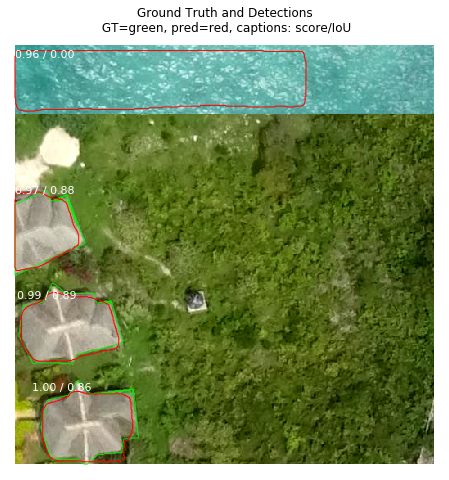

In [42]:
image_id = random.choice(dataset.image_ids)
image, image_meta, gt_class_id, gt_bbox, gt_mask =\
    modellib.load_image_gt(dataset, config, image_id, use_mini_mask=False)
info = dataset.image_info[image_id]
print("image ID: {}.{} ({}) {}".format(info["source"], info["id"], image_id, 
                                       dataset.image_reference(image_id)))
print("Original image shape: ", modellib.parse_image_meta(image_meta[np.newaxis,...])["original_image_shape"][0])

# Run object detection
results = model.detect_molded(np.expand_dims(image, 0), np.expand_dims(image_meta, 0), verbose=1)

# Display results
r = results[0]
log("gt_class_id", gt_class_id)
log("gt_bbox", gt_bbox)
log("gt_mask", gt_mask)

# Compute AP over range 0.5 to 0.95 and print it
utils.compute_ap_range(gt_bbox, gt_class_id, gt_mask,
                       r['rois'], r['class_ids'], r['scores'], r['masks'],
                       verbose=1)

visualize.display_differences(
    image,
    gt_bbox, gt_class_id, gt_mask,
    r['rois'], r['class_ids'], r['scores'], r['masks'],
    dataset.class_names, ax=get_ax(),
    show_box=False, show_mask=False,
    iou_threshold=0.5, score_threshold=0.5)

In [43]:
def compute_batch_ap(dataset, image_ids, verbose=1):
    APs = []
    for image_id in image_ids:
        # Load image
        image, image_meta, gt_class_id, gt_bbox, gt_mask =\
            modellib.load_image_gt(dataset, config,
                                   image_id, use_mini_mask=False)
        # Run object detection
        results = model.detect_molded(image[np.newaxis], image_meta[np.newaxis], verbose=0)
        # Compute AP over range 0.5 to 0.95
        r = results[0]
        ap = utils.compute_ap_range(
            gt_bbox, gt_class_id, gt_mask,
            r['rois'], r['class_ids'], r['scores'], r['masks'],
            verbose=0)
        APs.append(ap)
        if verbose:
            info = dataset.image_info[image_id]
            meta = modellib.parse_image_meta(image_meta[np.newaxis,...])
            print("{:3} {}   AP: {:.2f}".format(
                meta["image_id"][0], meta["original_image_shape"][0], ap))
    return APs

# Run on validation set
limit = 5
APs = compute_batch_ap(dataset, dataset.image_ids[:limit])
print("Mean AP overa {} images: {:.4f}".format(len(APs), np.mean(APs)))

  0 [512 512   3]   AP: 0.19
  1 [512 512   3]   AP: 0.33
  2 [512 512   3]   AP: 0.27
  3 [512 512   3]   AP: 0.36
  4 [512 512   3]   AP: 0.65
Mean AP overa 5 images: 0.3593


In [44]:
# Get anchors and convert to pixel coordinates
anchors = model.get_anchors(image.shape)
anchors = utils.denorm_boxes(anchors, image.shape[:2])
log("anchors", anchors)

# Generate RPN trainig targets
# target_rpn_match is 1 for positive anchors, -1 for negative anchors
# and 0 for neutral anchors.
target_rpn_match, target_rpn_bbox = modellib.build_rpn_targets(
    image.shape, anchors, gt_class_id, gt_bbox, model.config)
log("target_rpn_match", target_rpn_match)
log("target_rpn_bbox", target_rpn_bbox)

positive_anchor_ix = np.where(target_rpn_match[:] == 1)[0]
negative_anchor_ix = np.where(target_rpn_match[:] == -1)[0]
neutral_anchor_ix = np.where(target_rpn_match[:] == 0)[0]
positive_anchors = anchors[positive_anchor_ix]
negative_anchors = anchors[negative_anchor_ix]
neutral_anchors = anchors[neutral_anchor_ix]
log("positive_anchors", positive_anchors)
log("negative_anchors", negative_anchors)
log("neutral anchors", neutral_anchors)

# Apply refinement deltas to positive anchors
refined_anchors = utils.apply_box_deltas(
    positive_anchors,
    target_rpn_bbox[:positive_anchors.shape[0]] * model.config.RPN_BBOX_STD_DEV)
log("refined_anchors", refined_anchors, )

anchors                  shape: (65472, 4)            min: -181.00000  max:  629.00000  int32
target_rpn_match         shape: (65472,)              min:   -1.00000  max:    1.00000  int32
target_rpn_bbox          shape: (64, 4)               min:   -1.98841  max:    0.97656  float64
positive_anchors         shape: (4, 4)                min:  -32.00000  max:  512.00000  int32
negative_anchors         shape: (60, 4)               min:  -11.00000  max:  541.00000  int32
neutral anchors          shape: (65408, 4)            min: -181.00000  max:  629.00000  int32
refined_anchors          shape: (4, 4)                min:    0.00000  max:  512.00000  float32


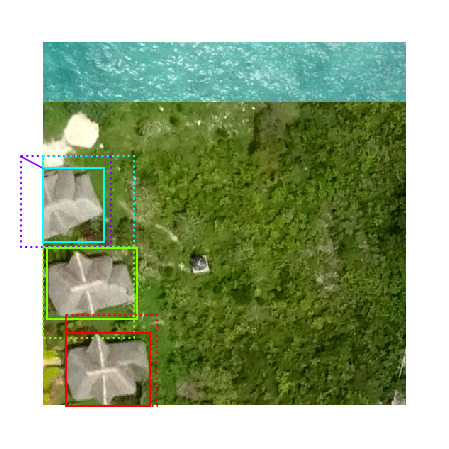

In [45]:
# Display positive anchors before refinement (dotted) and
# after refinement (solid).
visualize.draw_boxes(
    image, ax=get_ax(),
    boxes=positive_anchors,
    refined_boxes=refined_anchors)

In [46]:
# Run RPN sub-graph
pillar = model.keras_model.get_layer("ROI").output  # node to start searching from

# TF 1.4 and 1.9 introduce new versions of NMS. Search for all names to support TF 1.3~1.10
nms_node = model.ancestor(pillar, "ROI/rpn_non_max_suppression:0")
if nms_node is None:
    nms_node = model.ancestor(pillar, "ROI/rpn_non_max_suppression/NonMaxSuppressionV2:0")
if nms_node is None: #TF 1.9-1.10
    nms_node = model.ancestor(pillar, "ROI/rpn_non_max_suppression/NonMaxSuppressionV3:0")

rpn = model.run_graph(image[np.newaxis], [
    ("rpn_class", model.keras_model.get_layer("rpn_class").output),
    ("pre_nms_anchors", model.ancestor(pillar, "ROI/pre_nms_anchors:0")),
    ("refined_anchors", model.ancestor(pillar, "ROI/refined_anchors:0")),
    ("refined_anchors_clipped", model.ancestor(pillar, "ROI/refined_anchors_clipped:0")),
    ("post_nms_anchor_ix", nms_node),
    ("proposals", model.keras_model.get_layer("ROI").output),
], image_metas=image_meta[np.newaxis])

rpn_class                shape: (1, 65472, 2)         min:    0.00000  max:    1.00000  float32
pre_nms_anchors          shape: (1, 6000, 4)          min:   -0.35425  max:    1.22900  float32
refined_anchors          shape: (1, 6000, 4)          min:   -1.02535  max:    1.82090  float32
refined_anchors_clipped  shape: (1, 6000, 4)          min:    0.00000  max:    1.00000  float32
post_nms_anchor_ix       shape: (2000,)               min:    0.00000  max: 3623.00000  int32
proposals                shape: (1, 2000, 4)          min:    0.00000  max:    1.00000  float32


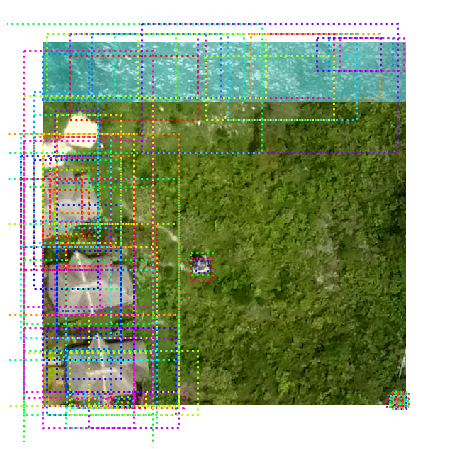

In [47]:
# Show top anchors by score (before refinement)
limit = 100
sorted_anchor_ids = np.argsort(rpn['rpn_class'][:,:,1].flatten())[::-1]
visualize.draw_boxes(image, boxes=anchors[sorted_anchor_ids[:limit]], ax=get_ax())

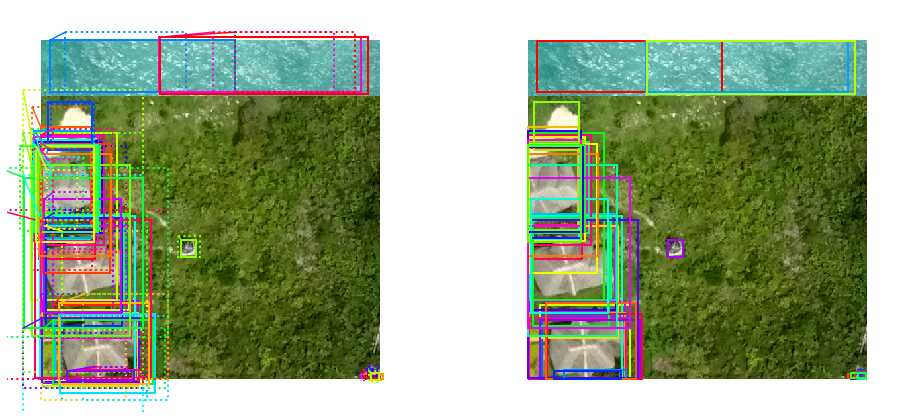

In [48]:
# Show top anchors with refinement. Then with clipping to image boundaries
limit = 50
ax = get_ax(1, 2)
pre_nms_anchors = utils.denorm_boxes(rpn["pre_nms_anchors"][0], image.shape[:2])
refined_anchors = utils.denorm_boxes(rpn["refined_anchors"][0], image.shape[:2])
refined_anchors_clipped = utils.denorm_boxes(rpn["refined_anchors_clipped"][0], image.shape[:2])
visualize.draw_boxes(image, boxes=pre_nms_anchors[:limit],
                     refined_boxes=refined_anchors[:limit], ax=ax[0])
visualize.draw_boxes(image, refined_boxes=refined_anchors_clipped[:limit], ax=ax[1])

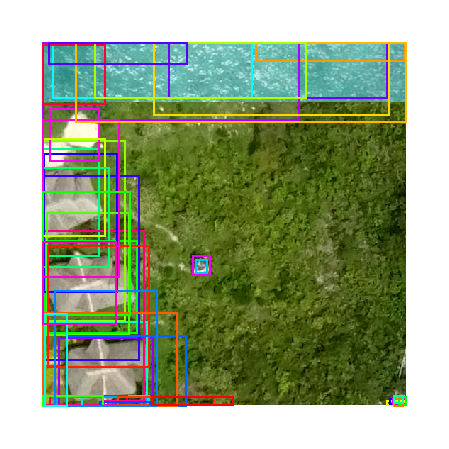

In [49]:
# Show refined anchors after non-max suppression
limit = 50
ixs = rpn["post_nms_anchor_ix"][:limit]
visualize.draw_boxes(image, refined_boxes=refined_anchors_clipped[ixs], ax=get_ax())

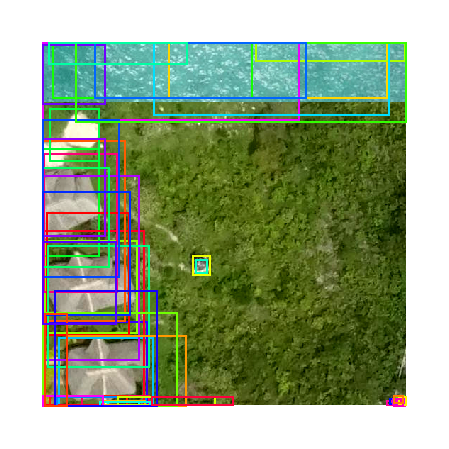

In [50]:
# Show final proposals
# These are the same as the previous step (refined anchors 
# after NMS) but with coordinates normalized to [0, 1] range.
limit = 50
# Convert back to image coordinates for display
# h, w = config.IMAGE_SHAPE[:2]
# proposals = rpn['proposals'][0, :limit] * np.array([h, w, h, w])
visualize.draw_boxes(
    image, ax=get_ax(),
    refined_boxes=utils.denorm_boxes(rpn['proposals'][0, :limit], image.shape[:2]))

In [51]:
# Get input and output to classifier and mask heads.
mrcnn = model.run_graph([image], [
    ("proposals", model.keras_model.get_layer("ROI").output),
    ("probs", model.keras_model.get_layer("mrcnn_class").output),
    ("deltas", model.keras_model.get_layer("mrcnn_bbox").output),
    ("masks", model.keras_model.get_layer("mrcnn_mask").output),
    ("detections", model.keras_model.get_layer("mrcnn_detection").output),
])

proposals                shape: (1, 2000, 4)          min:    0.00000  max:    1.00000  float32
probs                    shape: (1, 2000, 2)          min:    0.00000  max:    1.00000  float32
deltas                   shape: (1, 2000, 2, 4)       min:   -3.78792  max:    3.71522  float32
masks                    shape: (1, 200, 28, 28, 2)   min:    0.00490  max:    0.99999  float32
detections               shape: (1, 200, 6)           min:    0.00000  max:    1.00000  float32


4 detections: ['building' 'building' 'building' 'building']


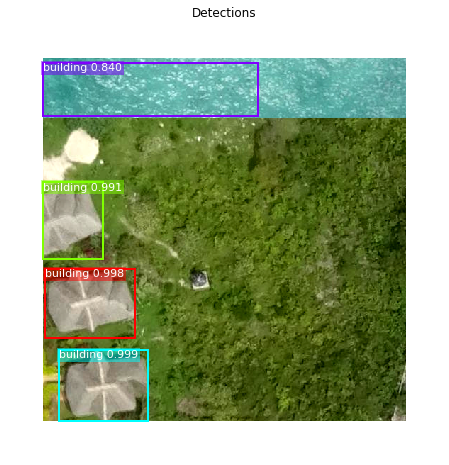

In [52]:
# Get detection class IDs. Trim zero padding.
det_class_ids = mrcnn['detections'][0, :, 4].astype(np.int32)
det_count = np.where(det_class_ids == 0)[0][0]
det_class_ids = det_class_ids[:det_count]
detections = mrcnn['detections'][0, :det_count]

print("{} detections: {}".format(
    det_count, np.array(dataset.class_names)[det_class_ids]))

captions = ["{} {:.3f}".format(dataset.class_names[int(c)], s) if c > 0 else ""
            for c, s in zip(detections[:, 4], detections[:, 5])]
visualize.draw_boxes(
    image, 
    refined_boxes=utils.denorm_boxes(detections[:, :4], image.shape[:2]),
    visibilities=[2] * len(detections),
    captions=captions, title="Detections",
    ax=get_ax())

In [53]:
# Proposals are in normalized coordinates
proposals = mrcnn["proposals"][0]

# Class ID, score, and mask per proposal
roi_class_ids = np.argmax(mrcnn["probs"][0], axis=1)
roi_scores = mrcnn["probs"][0, np.arange(roi_class_ids.shape[0]), roi_class_ids]
roi_class_names = np.array(dataset.class_names)[roi_class_ids]
roi_positive_ixs = np.where(roi_class_ids > 0)[0]

# How many ROIs vs empty rows?
print("{} Valid proposals out of {}".format(np.sum(np.any(proposals, axis=1)), proposals.shape[0]))
print("{} Positive ROIs".format(len(roi_positive_ixs)))

# Class counts
print(list(zip(*np.unique(roi_class_names, return_counts=True))))

2000 Valid proposals out of 2000
42 Positive ROIs
[('BG', 1958), ('building', 42)]


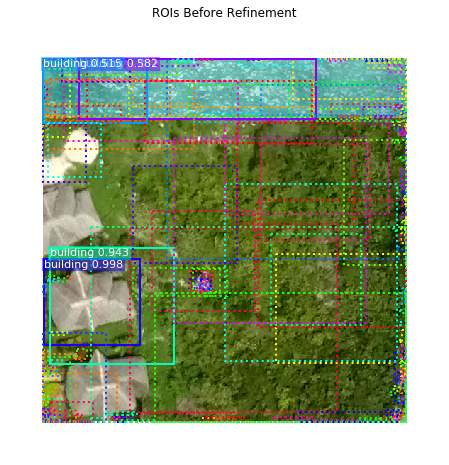

In [54]:
# Display a random sample of proposals.
# Proposals classified as background are dotted, and
# the rest show their class and confidence score.
limit = 200
ixs = np.random.randint(0, proposals.shape[0], limit)
captions = ["{} {:.3f}".format(dataset.class_names[c], s) if c > 0 else ""
            for c, s in zip(roi_class_ids[ixs], roi_scores[ixs])]
visualize.draw_boxes(
    image,
    boxes=utils.denorm_boxes(proposals[ixs], image.shape[:2]),
    visibilities=np.where(roi_class_ids[ixs] > 0, 2, 1),
    captions=captions, title="ROIs Before Refinement",
    ax=get_ax())

roi_bbox_specific        shape: (2000, 4)             min:   -3.68562  max:    3.19573  float32
refined_proposals        shape: (2000, 4)             min:   -0.11128  max:    1.12817  float32


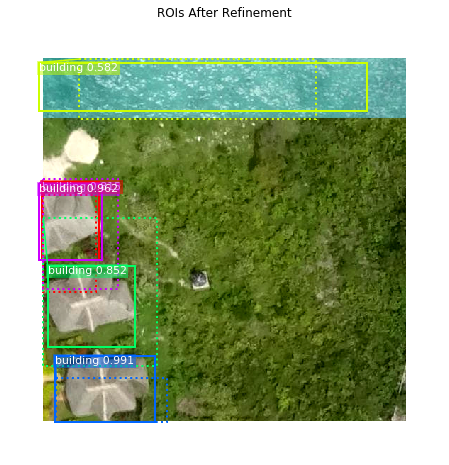

In [55]:
# Class-specific bounding box shifts.
roi_bbox_specific = mrcnn["deltas"][0, np.arange(proposals.shape[0]), roi_class_ids]
log("roi_bbox_specific", roi_bbox_specific)

# Apply bounding box transformations
# Shape: [N, (y1, x1, y2, x2)]
refined_proposals = utils.apply_box_deltas(
    proposals, roi_bbox_specific * config.BBOX_STD_DEV)
log("refined_proposals", refined_proposals)

# Show positive proposals
# ids = np.arange(roi_boxes.shape[0])  # Display all
limit = 5
ids = np.random.randint(0, len(roi_positive_ixs), limit)  # Display random sample
captions = ["{} {:.3f}".format(dataset.class_names[c], s) if c > 0 else ""
            for c, s in zip(roi_class_ids[roi_positive_ixs][ids], roi_scores[roi_positive_ixs][ids])]
visualize.draw_boxes(
    image, ax=get_ax(),
    boxes=utils.denorm_boxes(proposals[roi_positive_ixs][ids], image.shape[:2]),
    refined_boxes=utils.denorm_boxes(refined_proposals[roi_positive_ixs][ids], image.shape[:2]),
    visibilities=np.where(roi_class_ids[roi_positive_ixs][ids] > 0, 1, 0),
    captions=captions, title="ROIs After Refinement")

In [56]:
# Remove boxes classified as background
keep = np.where(roi_class_ids > 0)[0]
print("Keep {} detections:\n{}".format(keep.shape[0], keep))

Keep 42 detections:
[   0    1    2    3    6    7    8    9   12   17   25   31   34   35
   36   42   59   66   73   74  128  129  137  197  198  219  222  252
  266  311  438  487  526  625  666  734  852  915 1108 1308 1370 1604]


In [57]:
# Remove low confidence detections
keep = np.intersect1d(keep, np.where(roi_scores >= config.DETECTION_MIN_CONFIDENCE)[0])
print("Remove boxes below {} confidence. Keep {}:\n{}".format(
    config.DETECTION_MIN_CONFIDENCE, keep.shape[0], keep))

Remove boxes below 0 confidence. Keep 42:
[   0    1    2    3    6    7    8    9   12   17   25   31   34   35
   36   42   59   66   73   74  128  129  137  197  198  219  222  252
  266  311  438  487  526  625  666  734  852  915 1108 1308 1370 1604]


In [58]:
# Apply per-class non-max suppression
pre_nms_boxes = refined_proposals[keep]
pre_nms_scores = roi_scores[keep]
pre_nms_class_ids = roi_class_ids[keep]

nms_keep = []
for class_id in np.unique(pre_nms_class_ids):
    # Pick detections of this class
    ixs = np.where(pre_nms_class_ids == class_id)[0]
    # Apply NMS
    class_keep = utils.non_max_suppression(pre_nms_boxes[ixs], 
                                            pre_nms_scores[ixs],
                                            config.DETECTION_NMS_THRESHOLD)
    # Map indicies
    class_keep = keep[ixs[class_keep]]
    nms_keep = np.union1d(nms_keep, class_keep)
    print("{:22}: {} -> {}".format(dataset.class_names[class_id][:20], 
                                   keep[ixs], class_keep))

keep = np.intersect1d(keep, nms_keep).astype(np.int32)
print("\nKept after per-class NMS: {}\n{}".format(keep.shape[0], keep))

building              : [   0    1    2    3    6    7    8    9   12   17   25   31   34   35
   36   42   59   66   73   74  128  129  137  197  198  219  222  252
  266  311  438  487  526  625  666  734  852  915 1108 1308 1370 1604] -> [ 1  0  2 73]

Kept after per-class NMS: 4
[ 0  1  2 73]


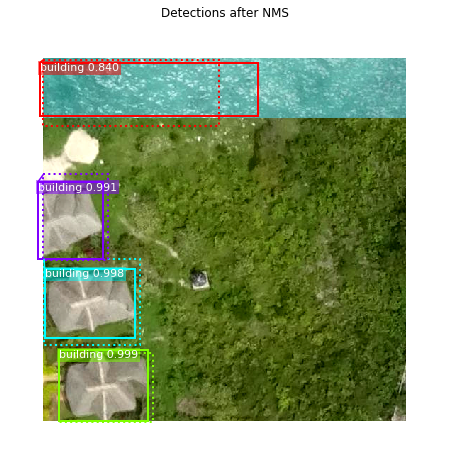

In [59]:
# Show final detections
ixs = np.arange(len(keep))  # Display all
# ixs = np.random.randint(0, len(keep), 10)  # Display random sample
captions = ["{} {:.3f}".format(dataset.class_names[c], s) if c > 0 else ""
            for c, s in zip(roi_class_ids[keep][ixs], roi_scores[keep][ixs])]
visualize.draw_boxes(
    image,
    boxes=utils.denorm_boxes(proposals[keep][ixs], image.shape[:2]),
    refined_boxes=utils.denorm_boxes(refined_proposals[keep][ixs], image.shape[:2]),
    visibilities=np.where(roi_class_ids[keep][ixs] > 0, 1, 0),
    captions=captions, title="Detections after NMS",
    ax=get_ax())

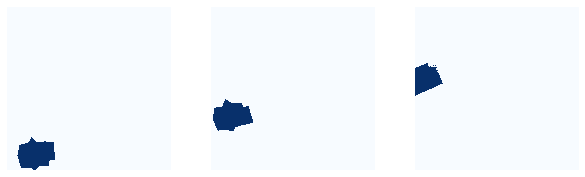

In [60]:
limit = 8
display_images(np.transpose(gt_mask[..., :limit], [2, 0, 1]), cmap="Blues")

In [61]:
# Get predictions of mask head
mrcnn = model.run_graph([image], [
    ("detections", model.keras_model.get_layer("mrcnn_detection").output),
    ("masks", model.keras_model.get_layer("mrcnn_mask").output),
])

# Get detection class IDs. Trim zero padding.
det_class_ids = mrcnn['detections'][0, :, 4].astype(np.int32)
det_count = np.where(det_class_ids == 0)[0][0]
det_class_ids = det_class_ids[:det_count]

print("{} detections: {}".format(
    det_count, np.array(dataset.class_names)[det_class_ids]))

detections               shape: (1, 200, 6)           min:    0.00000  max:    1.00000  float32
masks                    shape: (1, 200, 28, 28, 2)   min:    0.00490  max:    0.99999  float32
4 detections: ['building' 'building' 'building' 'building']


In [62]:
# Masks
det_boxes = utils.denorm_boxes(mrcnn["detections"][0, :, :4], image.shape[:2])
det_mask_specific = np.array([mrcnn["masks"][0, i, :, :, c] 
                              for i, c in enumerate(det_class_ids)])
det_masks = np.array([utils.unmold_mask(m, det_boxes[i], image.shape)
                      for i, m in enumerate(det_mask_specific)])
log("det_mask_specific", det_mask_specific)
log("det_masks", det_masks)

det_mask_specific        shape: (4, 28, 28)           min:    0.00490  max:    0.99999  float32
det_masks                shape: (4, 512, 512)         min:    0.00000  max:    1.00000  bool


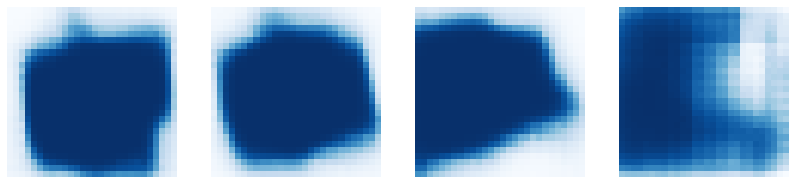

In [63]:
display_images(det_mask_specific[:4] * 255, cmap="Blues", interpolation="none")

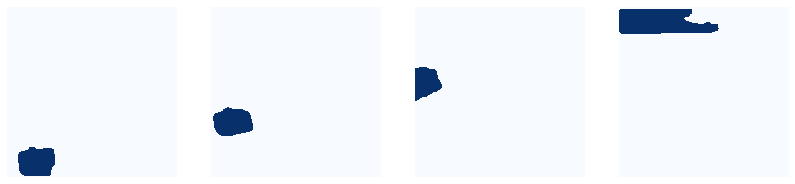

In [64]:
display_images(det_masks[:4] * 255, cmap="Blues", interpolation="none")

In [67]:
# Get activations of a few sample layers
activations = model.run_graph([image], [
    ("input_image",        tf.identity(model.keras_model.get_layer("input_image").output)),
    ("res2c_out",          model.keras_model.get_layer("res2c_out").output),
    ("res3c_out",          model.keras_model.get_layer("res3c_out").output),
    ("rpn_bbox",           model.keras_model.get_layer("rpn_bbox").output),
    ("roi",                model.keras_model.get_layer("ROI").output),
])

input_image              shape: (1, 512, 512, 3)      min: -128.77000  max:  155.46001  float32
res2c_out                shape: (1, 128, 128, 256)    min:    0.00000  max:   27.29198  float32
res3c_out                shape: (1, 64, 64, 512)      min:    0.00000  max:   29.29980  float32
rpn_bbox                 shape: (1, 65472, 4)         min:  -15.44994  max:   21.60991  float32
roi                      shape: (1, 2000, 4)          min:    0.00000  max:    1.00000  float32


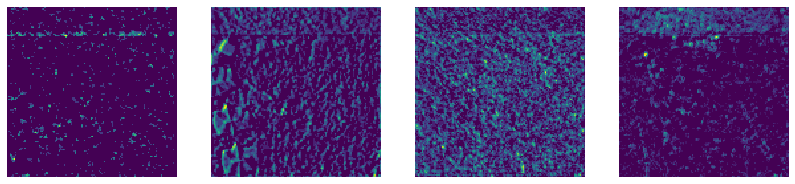

In [68]:
# Backbone feature map
display_images(np.transpose(activations["res2c_out"][0,:,:,:4], [2, 0, 1]), cols=4)